In [1]:
import sys
sys.path.append('core')

from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation ## FOR playing images as video on jupyter notebook
from IPython.display import HTML ## FOR playing images as video on jupyter notebook

import cv2
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import argparse

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

# 1. Generate Optical flow images from training video

## 1a. Load training video

Videos downloaded from comma ai speed challenge git repo:https://github.com/commaai/speedchallenge 

In [3]:
video_file = 'data/train.mp4'

Load video using openCV and copy all frames. Taking only first 100 frames for this demo

In [4]:
frames = []

cap_in = cv2.VideoCapture(video_file)
f_counter = 0  ## frame counter
while True:
    ret, frame = cap_in.read()
    if ret:
        f_counter += 1
        frames.append(frame)
    if f_counter == 100:
        break
# When everything done, release the capture
cap_in.release()

In [5]:
## openCV reads the frames in BGR format. So reformatting to RGB
frames = [cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in frames]

In [6]:
class Playable():
    """
    Play the frames as video inside jupyter notebook
    
    Args:
        frames (list): List of numpy arrays (frames to play)
        
    """
    def __init__(self, frames):
        self.frames = frames
        self.fig = plt.figure()
        self.im = plt.imshow(frames[0])
        plt.close() # this is required to not display the generated image

    def init_anim(self):
        self.im.set_data(self.frames[0])

    def animate(self, i):
        self.im.set_data(self.frames[i])
        return self.im
    def play(self):
        """
        Play the frames
        """
        anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.init_anim, frames=len(self.frames), interval=100)
        return HTML(anim.to_html5_video())

In [7]:
Playable(frames).play()

## 1b. Preprocess images (brightness adjusting and cropping) 

Since two consecttive frames are compared as input to the RAFT network, it might be better to remove any large brighness differences between the two frames so as not to influence the network's decision. So adding a constant uniform brightness factor to both the frames.

Also since the top sky part and bottom car's hood part almost remains constant throughout the video, cropping those out too.

In [8]:
def brightness_adjust_and_crop(image, bright_factor):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb[100:440, :, :]

In [9]:
def preprocess(prev_frame, curr_frame):
    bright_factor = 0.7 + np.random.uniform()
    prev_frame, curr_frame = brightness_adjust_and_crop(prev_frame, bright_factor), brightness_adjust_and_crop(curr_frame, bright_factor)
    return prev_frame, curr_frame

In [10]:
## applying preprocessing to all the frame pairs
preprocessed_frames = [preprocess(frames[min(0, i-1)], frames[i]) for i in range(len(frames))]

In [11]:
## to display the preprocessed frames
pf = [f[1] for f in preprocessed_frames]

In [12]:
Playable(pf).play()

## 1c. Load pretrained RAFT model

RAFT (Recurrent All Pairs Field Transforms for Optical Flow) model pretrained on FlyingThings3D dataset (raft-things.pth) and code is downloaded from https://github.com/princeton-vl/RAFT

In [13]:
## add dummy args for loading RAFT model
sys.argv = ['foo']
parser = argparse.ArgumentParser()
args = parser.parse_args()

## create model object
model = torch.nn.DataParallel(RAFT(args), device_ids=[0])
model.to(device)
## load model
model.load_state_dict(torch.load('models/raft-things.pth'))

<All keys matched successfully>

## 1d. Generate optical flow images for all frames

In [14]:
flo_frames = []
for i in range(len(frames)-1):
    ## take consecutive frames
    im1 = torch.from_numpy(frames[i]).permute(2,0,1).float().unsqueeze(axis=0).to(device)
    im2 = torch.from_numpy(frames[i+1]).permute(2,0,1).float().unsqueeze(axis=0).to(device)
    ## Pad images such that dimensions are divisible by 8 (see RAFT paper)
    padder = InputPadder(im1.shape)
    im1, im2 = padder.pad(im1, im2)
    
    ## generate optical flow image which is a 2channel UV format image
    _, flo = model(im1, im2, iters=20, test_mode=True)
    flo = flo[0].permute(1,2,0).detach().cpu().numpy()
    # format flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    flo_frames.append(flo)

In [15]:
Playable(flo_frames).play()

In [16]:
flo_frames = []
for i in range(len(preprocessed_frames)):
    ## take consecutive frames
    im1 = torch.from_numpy(preprocessed_frames[i][0]).permute(2,0,1).float().unsqueeze(axis=0).to(device)
    im2 = torch.from_numpy(preprocessed_frames[i][1]).permute(2,0,1).float().unsqueeze(axis=0).to(device)
    ## Pad images such that dimensions are divisible by 8 (see RAFT paper)
    padder = InputPadder(im1.shape)
    im1, im2 = padder.pad(im1, im2)
    
    ## generate optical flow image which is a 2channel UV format image
    _, flo = model(im1, im2, iters=20, test_mode=True)
    flo = flo[0].permute(1,2,0).detach().cpu().numpy()
    # format flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    flo_frames.append(flo)

In [17]:
Playable(flo_frames).play()

# 2. Create PyTorch dataset of optical flow images

Create a pytorch dataset with the generated optical flow images as features and speeds at each frame as target values

In [16]:
speeds_file = 'data/train.txt'

In [17]:
y = np.loadtxt(speeds_file)

In [29]:
y = y[:99]

In [30]:
TT = transforms.ToTensor()

In [31]:
def create_tensor_dataset(x, y, transform):
    X_torch = torch.stack([transform(img) for img in x])
    y_torch = torch.from_numpy(y)
    y_torch = y_torch.float()
    dataset = torch.utils.data.TensorDataset(X_torch, y_torch)
    return(dataset)

Splitting the dataset into training data (80%) and validation data (20%) to evaluate the performance during training

In [32]:
train_val_split = int(np.floor(0.8*len(y)))

In [33]:
x_train = flo_frames[:train_val_split]
y_train = y[:train_val_split]

x_val = flo_frames[train_val_split:]
y_val = y[train_val_split:]

In [34]:
train_set = create_tensor_dataset(x_train,y_train,TT)
val_set = create_tensor_dataset(x_val,y_val,TT)

In [35]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,num_workers=8, shuffle=True)

In [36]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32,num_workers=8, shuffle=False)

# 3. Train a regression network with optical flow images and corresponding speeds

## 3a. Define the network

Using the same network from NVIDIA's end-to-end deep learning for self-driving cars blog post: https://developer.nvidia.com/blog/deep-learning-self-driving-cars/

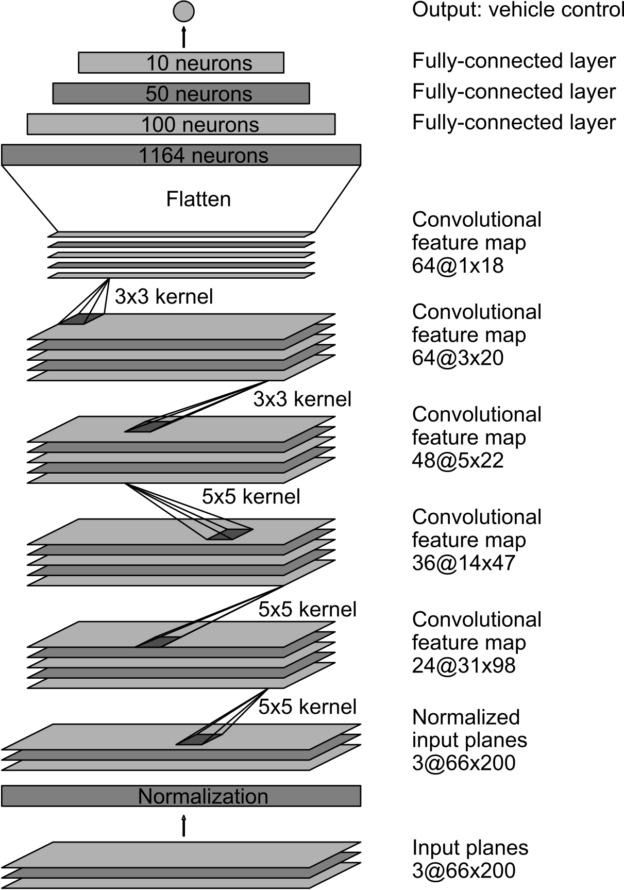

This network was used in the above blog to train the network on steering angle from the center camera images

In [48]:
# TODO: normalization
class NVIDIA(nn.Module):
    """https://developer.nvidia.com/blog/deep-learning-self-driving-cars/"""

    def __init__(self):
        super(NVIDIA, self).__init__()
        self.conv1 = conv(3, 24, kernel_size=5, stride=2)
        self.conv2 = conv(24, 36, kernel_size=5, stride=2)
        self.conv3 = conv(36, 48, kernel_size=5, stride=2)
        self.conv4 = conv(48, 48, kernel_size=5, stride=2)
        self.drop = nn.Dropout2d(p=0.5)
        self.conv5 = conv(48, 64, kernel_size=3, stride=1)
        self.conv6 = conv(64, 64, kernel_size=3, stride=1)
        self.conv7 = conv(64, 64, kernel_size=3, stride=1)
        self.conv8 = conv(64, 64, kernel_size=3, stride=1)
        self.linear1 = linear(64*19*29, 100)
        self.linear2 = linear(100, 50)
        self.linear3 = linear(50, 10)
        self.linear4 = nn.Linear(10, 1)

        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight.data, mode='fan_in')
                if layer.bias is not None:
                    layer.bias.data.zero_()


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.drop(self.conv5(x))
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(-1, 64*19*29)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x.squeeze(1)


def conv(in_planes, out_planes, kernel_size=5, stride=1, padding=0, dilation=1):
    return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                        padding=padding, dilation=dilation, bias=True),
            nn.ELU())


def linear(in_features, out_features):
    return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ELU())

## 3b. Train the network

In [46]:
def train(train_loader, val_loader, save_model_path, epochs):
    device = torch.device('cuda')
    model = NVIDIA().to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
        patience=0, threshold=0.2, threshold_mode='abs', min_lr=1e-8,)
    print('Start training ...')
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        training_loss = 0
        val_loss = 0
        for i, (flow_stack, speed_vector) in enumerate(train_loader):
            flow_stack, speed_vector = flow_stack.to(device), speed_vector.to(device)
            optimizer.zero_grad()
            pred_speed = model(flow_stack)
            loss = criterion(pred_speed, speed_vector)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        model.eval()
        for i, (flow_stack, speed_vector) in enumerate(val_loader):
            flow_stack, speed_vector = flow_stack.to(device), speed_vector.to(device)
            with torch.no_grad():
                pred_speed = model(flow_stack)
                loss = criterion(pred_speed, speed_vector)
                val_loss += loss.item()
        training_loss = training_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        print("epoch: ", epoch, training_loss, val_loss)
        train_losses.append(training_loss)
        
        val_losses.append(val_loss)
        scheduler.step(training_loss)
    print('Training complete!')
    torch.save(model.state_dict(), save_model_path)
    print('Model saved!')
    return train_losses, val_losses

In [47]:
t_losses, v_losses = train(train_loader, val_loader, './nvidia-opticalflow.pth', 20)

Start training ...
torch.Size([32, 64, 19, 29])
torch.Size([32, 64, 19, 29])
torch.Size([15, 64, 19, 29])
torch.Size([20, 64, 19, 29])
epoch:  0 675.6032918294271 508.23858642578125
torch.Size([32, 64, 19, 29])
torch.Size([32, 64, 19, 29])
torch.Size([15, 64, 19, 29])
torch.Size([20, 64, 19, 29])
epoch:  1 414.13002522786456 157.7571563720703
torch.Size([32, 64, 19, 29])
torch.Size([32, 64, 19, 29])
torch.Size([15, 64, 19, 29])
torch.Size([20, 64, 19, 29])
epoch:  2 85.36587015787761 60.08143997192383
torch.Size([32, 64, 19, 29])
torch.Size([32, 64, 19, 29])
torch.Size([15, 64, 19, 29])
torch.Size([20, 64, 19, 29])
epoch:  3 132.8763860066732 62.161720275878906
torch.Size([32, 64, 19, 29])
torch.Size([32, 64, 19, 29])
torch.Size([15, 64, 19, 29])
torch.Size([20, 64, 19, 29])
epoch:  4 133.40322875976562 39.28799057006836
torch.Size([32, 64, 19, 29])
torch.Size([32, 64, 19, 29])
torch.Size([15, 64, 19, 29])
torch.Size([20, 64, 19, 29])
epoch:  5 87.22890218098958 36.747825622558594
torc

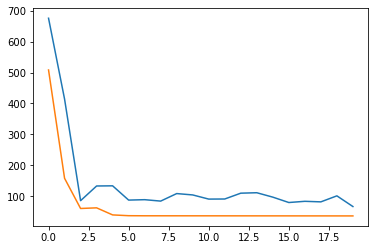

In [49]:
plt.plot(t_losses)
plt.plot(v_losses)